In [ ]:
import os
import sys
import requests

import h5py
import matplotlib.pyplot as plt
import numpy as np
from convert_rrsg_data import convert_data
from types import SimpleNamespace

In [2]:
# Download data from Zenodo
if not os.path.isdir('rrsg_data'):
    os.mkdir('rrsg_data')
    
zenodo_files=["rawdata_brain_radial_96proj_12ch.h5", "rawdata_spiral_ETH.h5"]

for f in zenodo_files:
    
    if not os.path.isfile("rrsg_data/%s"%f):
        print("Downloading %s"%f)
        res = requests.get('https://zenodo.org/record/3975887/files/%s'%f)
        with open('rrsg_data/%s'%f, 'wb') as h5f:
            h5f.write(res.content)
    print("Already downloaded %s"%f)

Already downloaded rawdata_brain_radial_96proj_12ch.h5
Already downloaded rawdata_spiral_ETH.h5


In [3]:
if not os.path.isdir('rrsg_recon'):
    os.mkdir('rrsg_recon')

In [6]:
# Convert to riesling format
if not os.path.isdir('riesling_data'):
    os.mkdir('riesling_data')
    
f = 'rawdata_brain_radial_96proj_12ch.h5'
convert_data(input_fname='rrsg_data/%s' % f,
             output_fname='riesling_data/riesling_%s' % f,
             matrix=[256, 256, 1], voxel_size=[0.78, 0.78, 2])

f = 'rawdata_spiral_ETH.h5'
convert_data(input_fname='rrsg_data/%s' % f,
             output_fname='riesling_data/riesling_%s' % f,
             matrix=[220, 220, 1], voxel_size=[1, 1, 2])

H5 file saved to riesling_data/riesling_rawdata_brain_radial_96proj_12ch.h5
H5 file saved to riesling_data/riesling_rawdata_spiral_ETH.h5


H5 datasets: <KeysViewHDF5 ['info', 'noncartesian', 'trajectory']>
Trajectory shape: (96, 512, 3)
Data shape: (1, 96, 512, 12)

--- Riesling header ---
Header
Matrix: 256 256   1
Voxel-size: 0.78 0.78    2
Read points: 512 Gap: 0
Hi-res spokes: 96 Lo-res spokes: 0 Lo-res scale: 8
Channels: 12 Volumes: 1 TR: 1
Origin: 0 0 0
Direction:
1 0 0
0 1 0
0 0 1


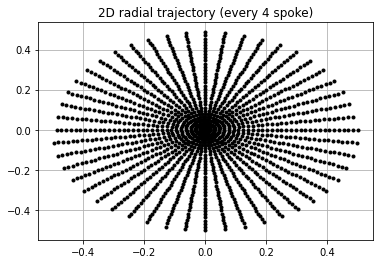

In [62]:
h5_file = 'riesling_data/riesling_rawdata_brain_radial_96proj_12ch.h5'
with h5py.File(h5_file) as f:
    print("H5 datasets: {}".format(f.keys()))
    print("Trajectory shape: {}".format(f['trajectory'].shape))
    print("Data shape: {}".format(f['noncartesian'].shape))
    traj = np.array(f['trajectory'])

plt.figure()
plt.grid()
n_spoke = 4
plt.plot(traj[::n_spoke,::8,0], traj[::n_spoke,::8,1], '.k')
plt.title('2D radial trajectory (every %d spoke)'%n_spoke)

print("\n--- Riesling header ---")
!riesling hdr {h5_file}

H5 datasets: <KeysViewHDF5 ['info', 'noncartesian', 'trajectory']>
Trajectory shape: (3, 27121, 3)
Data shape: (1, 3, 27121, 16)

--- Riesling header ---
Header
Matrix: 220 220   1
Voxel-size: 1 1 2
Read points: 27121 Gap: 0
Hi-res spokes: 3 Lo-res spokes: 0 Lo-res scale: 8
Channels: 16 Volumes: 1 TR: 1
Origin: 0 0 0
Direction:
1 0 0
0 1 0
0 0 1


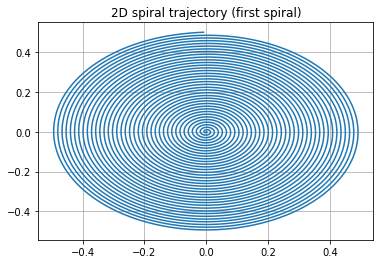

In [73]:
h5_file = 'riesling_data/riesling_rawdata_spiral_ETH.h5'
with h5py.File(h5_file) as f:
    print("H5 datasets: {}".format(f.keys()))
    print("Trajectory shape: {}".format(f['trajectory'].shape))
    print("Data shape: {}".format(f['noncartesian'].shape))
    traj = np.array(f['trajectory'])

plt.figure()
plt.grid()
n_spoke = 4
plt.plot(traj[0,:,0], traj[0,:,1])
plt.title('2D spiral trajectory (first spiral)')

print("\n--- Riesling header ---")
!riesling hdr {h5_file}

In [84]:
if not os.path.isdir('riesling_recon'):
    os.mkdir('riesling_recon')
    
h5_in = 'riesling_data/riesling_rawdata_brain_radial_96proj_12ch.h5'
h5_out = 'riesling_recon/rrsg_challenge_brain'
fov = 234
!riesling recon --fov={fov} --sdc=pipe --os 2.5 --out={h5_out} {h5_in}
!riesling tgv --fov={fov} --sdc=pipe --os 2.5 -i 8 --alpha=1E-6  --out={h5_out} {h5_in}
!riesling cg --fov={fov} --sdc=pipe --os 2.5 --out={h5_out} {h5_in}

h5_in = 'riesling_data/riesling_rawdata_spiral_ETH.h5'
h5_out = 'riesling_recon/rrsg_challenge_spiral'
FOV=240
!riesling recon --fov={FOV} --sdc=pipe --out={h5_out} {h5_in}
!riesling cg --fov={FOV} --sdc=pipe --out={h5_out} {h5_in}
!riesling tgv --fov={FOV} --sdc=pipe --out={h5_out} {h5_in}

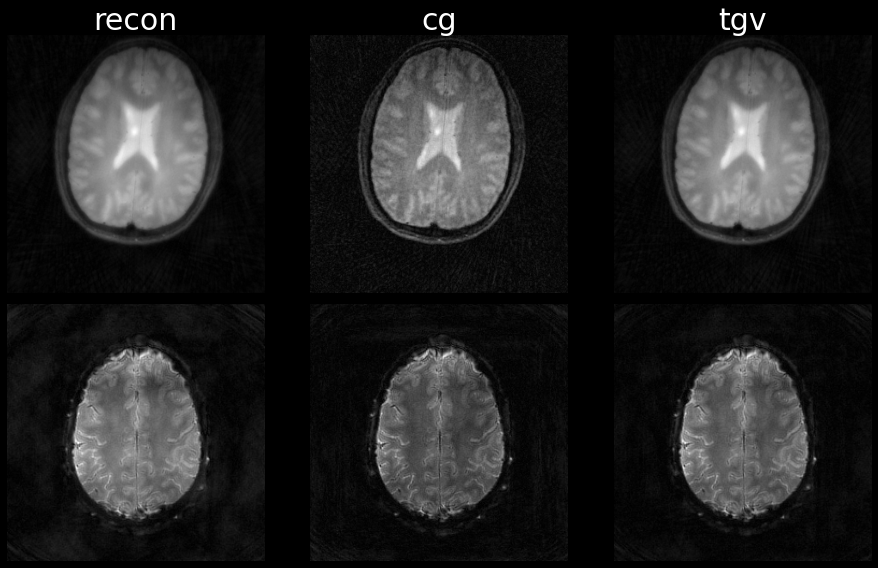

In [87]:
img_radial = {}
for recon in ['recon', 'cg', 'tgv']:
    with h5py.File('riesling_recon/rrsg_challenge_brain-%s.h5'%recon) as f:
        img_radial[recon] = f['image'][:]

img_spiral = {}
for recon in ['recon', 'cg', 'tgv']:
    with h5py.File('riesling_recon/rrsg_challenge_spiral-%s.h5'%recon) as f:
        img_spiral[recon] = f['image'][:]
    
    
fig = plt.figure(figsize=(13,8), facecolor='black')

for (i,recon) in enumerate(['recon', 'cg', 'tgv']):
    fig.add_subplot(2,3,i+1)
    plt.imshow(np.rot90(abs(img_radial[recon][0,0,:,:]),1), cmap='gray'); plt.axis('off')
    plt.title(recon, color='w', size=30)
    
    fig.add_subplot(2,3,i+4)
    plt.imshow(np.rot90(abs(img_spiral[recon][0,0,:,:]),3), cmap='gray'); plt.axis('off')

plt.tight_layout()
